# Final project

```
Ezequiel Cimadevilla Álvarez
ezequiel.cimadevilla@unican.es

Santander Meteorology Group
Instituto de Física de Cantabria
Edificio Juan Jordá, Avenida de los Castros, s/n, E-39005 Santander, Cantabria, Spain

http://www.meteo.unican.es

Máster Data Science/Ciencia de Datos - 2023/2024
```

## Introduction

The [Coupled Model Intercomparison Project Phase 6 (CMIP6)](https://pcmdi.llnl.gov/CMIP6/) is the 6th phase of the CMIP project, a global initiative where modelling institutions around the globe share the results of their simulations (climate models), in order to make them availble worldwide for scientific research.

For this task, we will work again with datasets of temperature and precipitation from [CMIP](https://en.wikipedia.org/wiki/Coupled_Model_Intercomparison_Project) from the [ACCESS-ESM1-5 model](https://research.csiro.au/access/about/esm1-5/). Remember that the GCM is described in the [paper](https://doi.org/10.1071/ES19035) and the netCDF files can be located in [ESGF](https://esgf-node.llnl.gov/search/cmip6?mip_era=CMIP6&activity_id=ScenarioMIP&product=&source_id=ACCESS-CM2%2CACCESS-ESM1-5&experiment_id=ssp245%2Cssp585&variant_label=r1i1p1f1%2Cr1i1p1f2&grid_label=gn&table_id=&frequency=day%2Cmon&variable_id=tas) (the files for this exercise can be located in Moodle too).

- tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc
- tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_210101-230012.nc
- tas_Amon_ACCESS-ESM1-5_ssp585_r2i1p1f1_gn_201501-210012.nc
- tas_Amon_ACCESS-ESM1-5_ssp585_r2i1p1f1_gn_210101-230012.nc
- pr_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc
- pr_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_210101-230012.nc
- pr_Amon_ACCESS-ESM1-5_ssp585_r2i1p1f1_gn_201501-210012.nc
- pr_Amon_ACCESS-ESM1-5_ssp585_r2i1p1f1_gn_210101-230012.nc

Note that:

- Four files must belong to `tas` and four files must belong to `pr`, following the same time series.
- Monthly frequency.
- Two "variant labels" (`r1i1p1f1` and `r2i1p1f1`). For a given experiment, the realization_index (`r`), initialization_index (`i`), physics_index (`p`), and forcing_index (`f`) are used to uniquely identify each simulation of an ensemble of runs contributed by a single model.
- `ssp585` experiment_id, see [Wikipedia](https://en.wikipedia.org/wiki/Shared_Socioeconomic_Pathways).

## Objectives

- Perform a scientific ETL in order to produce a virtual analysis ready dataset.

## Scientific ETL
Using h5py, create a Virtual Dataset that contains all the data included in the previous files that you have just downloaded. Note that:

- `lat` and `lon` values are shared between files.
- `time` needs to be extended to store values from the whole time series.
- `pr` and `tas` need to be 4-dimensional, so you need to create an additional dimension named `variant_label`.
  - ...
  - `variant_label(variant_label)`
  - `time(time)`
  - `pr(variant_label, time, lat, lon)`
  - `tas(variant_label, time, lat, lon)`
- `variant_label` dimension will be of type string and size 2.
- Note that `tas` datasets include an additional variable named `height`.
- Remember to include `time_bnds`, `lat_bnds` and `lon_bnds` variables too.

In [2]:
import h5py
import numpy as np
import xarray
import cartopy.crs as ccrs

In [32]:

tas_sim1_2015 = h5py.File("tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc")
tas_sim1_2101 = h5py.File("tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_210101-230012.nc")
tas_sim2_2015 = h5py.File("tas_Amon_ACCESS-ESM1-5_ssp585_r2i1p1f1_gn_201501-210012.nc")
tas_sim2_2101 = h5py.File("tas_Amon_ACCESS-ESM1-5_ssp585_r2i1p1f1_gn_210101-230012.nc")
pr_sim1_2015 = h5py.File("pr_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc")
pr_sim1_2101 = h5py.File("pr_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_210101-230012.nc")
pr_sim2_2015 = h5py.File("pr_Amon_ACCESS-ESM1-5_ssp585_r2i1p1f1_gn_201501-210012.nc")
pr_sim2_2101 = h5py.File("pr_Amon_ACCESS-ESM1-5_ssp585_r2i1p1f1_gn_210101-230012.nc")


with h5py.File("project.nc", "w") as f:

    #creamos virtual datasets
    #dataset time
    joined_time = tas_sim1_2015["time"].shape[0] + tas_sim1_2101["time"].shape[0]
    layout = h5py.VirtualLayout(shape=(joined_time,), dtype=tas_sim1_2015["time"].dtype)
    end = tas_sim1_2015["time"].shape[0]
    layout[0:end] = h5py.VirtualSource(tas_sim1_2015.filename, "time", tas_sim1_2015["time"].shape)
    layout[end:] = h5py.VirtualSource(tas_sim1_2101.filename, "time", tas_sim1_2101["time"].shape) 
    f.create_virtual_dataset("time", layout)
    for atributo in dict(tas_sim1_2015["time"].attrs).keys():
        f["time"].attrs.create(atributo, tas_sim1_2015["time"].attrs[atributo])
    
    #dataset lat
    lenlat = tas_sim1_2015["lat"].shape[0] 
    layout = h5py.VirtualLayout(shape=(lenlat,), dtype=tas_sim1_2015["lat"].dtype)
    layout[0:lenlat] = h5py.VirtualSource(tas_sim1_2015.filename, "lat", tas_sim1_2015["lat"].shape)
    f.create_virtual_dataset("lat", layout)
    for atributo in dict(tas_sim1_2015["lat"].attrs).keys():
        f["lat"].attrs.create(atributo, tas_sim1_2015["lat"].attrs[atributo])

    #dataset lon
    lenlon = tas_sim1_2015["lon"].shape[0] 
    layout = h5py.VirtualLayout(shape=(lenlon,), dtype=tas_sim1_2015["lon"].dtype)
    layout[0:lenlon] = h5py.VirtualSource(tas_sim1_2015.filename, "lon", tas_sim1_2015["lon"].shape)
    f.create_virtual_dataset("lon", layout)
    for atributo in dict(tas_sim1_2015["lon"].attrs).keys():
        f["lon"].attrs.create(atributo, tas_sim1_2015["lon"].attrs[atributo])
    
    #dataset bnds
    lenbnds = tas_sim1_2015["bnds"].shape[0] 
    layout = h5py.VirtualLayout(shape=(lenbnds,), dtype=tas_sim1_2015["bnds"].dtype)
    layout[0:lenbnds] = h5py.VirtualSource(tas_sim1_2015.filename, "bnds", tas_sim1_2015["bnds"].shape)
    f.create_virtual_dataset("bnds", layout)
    for atributo in dict(tas_sim1_2015["bnds"].attrs).keys():
        f["bnds"].attrs.create(atributo, tas_sim1_2015["bnds"].attrs[atributo])
        
    #dataset variant_label
    f["variant_label"] = ["r1i1p1f1", "r2i1p1f1"]
    f["variant_label"].attrs.create("standard_name", b"realization", dtype="S11")


    #datset height
    layout = h5py.VirtualLayout(shape=(), dtype=tas_sim1_2015["height"].dtype)
    layout[()] = h5py.VirtualSource(tas_sim1_2015.filename, "height", tas_sim1_2015["height"].shape)
    f.create_virtual_dataset("height", layout)
    for atributo in dict(tas_sim1_2015["height"].attrs).keys():
        f["height"].attrs.create(atributo, tas_sim1_2015["height"].attrs[atributo])
        
    #dataset lon_bnds
    dim1= tas_sim1_2015["lon"].shape[0] 
    dim2=tas_sim1_2015["bnds"].shape[0] 
    layout = h5py.VirtualLayout(shape=(dim1,dim2), dtype=tas_sim1_2015["lon_bnds"].dtype)
    layout[...] = h5py.VirtualSource(tas_sim1_2015.filename, "lon_bnds", tas_sim1_2015["lon_bnds"].shape)
    f.create_virtual_dataset("lon_bnds", layout)
        
    #dataset lat_bnds
    dim1= tas_sim1_2015["lat"].shape[0] 
    dim2=tas_sim1_2015["bnds"].shape[0] 
    layout = h5py.VirtualLayout(shape=(dim1,dim2), dtype=tas_sim1_2015["lat_bnds"].dtype)
    layout[...] = h5py.VirtualSource(tas_sim1_2015.filename, "lat_bnds", tas_sim1_2015["lat_bnds"].shape)
    f.create_virtual_dataset("lat_bnds", layout)

    
    #dataset time_bnds
    dim1= tas_sim1_2015["time"].shape[0] + tas_sim1_2101["time"].shape[0]
    dim2=tas_sim1_2015["bnds"].shape[0] 
    layout = h5py.VirtualLayout(shape=(dim1,dim2), dtype=tas_sim1_2015["time_bnds"].dtype)
    end = tas_sim1_2015["time"].shape[0]
    layout[0:end] = h5py.VirtualSource(tas_sim1_2015.filename, "time_bnds", tas_sim1_2015["time_bnds"].shape)
    layout[end:] = h5py.VirtualSource(tas_sim1_2101.filename, "time_bnds", tas_sim1_2101["time_bnds"].shape)
    f.create_virtual_dataset("time_bnds", layout)

    
    #dataset tas
    lenvar = f['variant_label'].shape[0]
    layout = h5py.VirtualLayout(shape=(lenvar,joined_time,lenlat,lenlon), dtype=tas_sim1_2015["tas"].dtype)
    end = tas_sim1_2015["time"].shape[0]
    layout[0,0:end] = h5py.VirtualSource(tas_sim1_2015.filename, "tas", tas_sim1_2015["tas"].shape)
    layout[0,end:] = h5py.VirtualSource(tas_sim1_2101.filename, "tas", tas_sim1_2101["tas"].shape)
    layout[1,0:end] = h5py.VirtualSource(tas_sim2_2015.filename, "tas", tas_sim2_2015["tas"].shape)
    layout[1,end:] = h5py.VirtualSource(tas_sim2_2101.filename, "tas", tas_sim2_2101["tas"].shape)
    f.create_virtual_dataset("tas", layout)
    for atributo in dict(tas_sim1_2015["tas"].attrs).keys():
        if atributo not in np.array(["DIMENSION_LIST"]) and not atributo.startswith("_"):
            f["tas"].attrs.create(atributo, tas_sim1_2015["tas"].attrs[atributo])
    
        
    #dataset pr
    layout = h5py.VirtualLayout(shape=(lenvar,joined_time,lenlat,lenlon), dtype=pr_sim1_2015["pr"].dtype)
    layout[0,0:end] = h5py.VirtualSource(pr_sim1_2015.filename, "pr", pr_sim1_2015["pr"].shape)
    layout[0,end:] = h5py.VirtualSource(pr_sim1_2101.filename, "pr", pr_sim1_2101["pr"].shape)
    layout[1,0:end] = h5py.VirtualSource(pr_sim2_2015.filename, "pr", pr_sim2_2015["pr"].shape)
    layout[1,end:] = h5py.VirtualSource(pr_sim2_2101.filename, "pr", pr_sim2_2101["pr"].shape)
    f.create_virtual_dataset("pr", layout)
    f["pr"].attrs.create('units', pr_sim1_2015["pr"].attrs['units'])
    for atributo in dict(pr_sim1_2015["pr"].attrs).keys():
        if atributo not in np.array(["DIMENSION_LIST"]) and not atributo.startswith("_"):
            f["pr"].attrs.create(atributo, pr_sim1_2015["pr"].attrs[atributo])


    #creamos dimension scales
    #tas
    f["variant_label"].make_scale("variant_label")
    f["time"].make_scale("time")
    f["lat"].make_scale("lat")
    f["lon"].make_scale("lon")
    
    f["tas"].dims[0].attach_scale(f["variant_label"])
    f["tas"].dims[1].attach_scale(f["time"])
    f["tas"].dims[2].attach_scale(f["lat"])
    f["tas"].dims[3].attach_scale(f["lon"])

    #pr
    f["pr"].dims[0].attach_scale(f["variant_label"])
    f["pr"].dims[1].attach_scale(f["time"])
    f["pr"].dims[2].attach_scale(f["lat"])
    f["pr"].dims[3].attach_scale(f["lon"])

    #time_bnds
    f["bnds"].make_scale("bnds")
    f["time_bnds"].dims[0].attach_scale(f["time"])
    f["time_bnds"].dims[1].attach_scale(f["bnds"])
    
    #lat_bnds
    f["lat_bnds"].dims[0].attach_scale(f["lat"])
    f["lat_bnds"].dims[1].attach_scale(f["bnds"])
    
    #lon_bnds
    f["lon_bnds"].dims[0].attach_scale(f["lon"])
    f["lon_bnds"].dims[1].attach_scale(f["bnds"])


    
tas_sim1_2015.close()
tas_sim1_2101.close()
tas_sim2_2015.close()
tas_sim2_2101.close()
pr_sim1_2015.close()
pr_sim1_2101.close()
pr_sim2_2015.close()
pr_sim2_2101.close()

In [35]:
!ncdump -hs project.nc

netcdf project {
dimensions:
	time = 3432 ;
	lat = 145 ;
	lon = 192 ;
	bnds = 2 ;
	variant_label = 2 ;
variables:
	float bnds(bnds) ;
		bnds:_Storage = "unknown" ;
		bnds:_Endianness = "big" ;
		bnds:_NoFill = "true" ;
	double height ;
		height:units = "m" ;
		height:axis = "Z" ;
		height:positive = "up" ;
		height:long_name = "height" ;
		height:standard_name = "height" ;
		height:_Storage = "unknown" ;
		height:_Endianness = "little" ;
		height:_NoFill = "true" ;
	double lat(lat) ;
		lat:bounds = "lat_bnds" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
		lat:long_name = "Latitude" ;
		lat:standard_name = "latitude" ;
		lat:_Storage = "unknown" ;
		lat:_Endianness = "little" ;
		lat:_NoFill = "true" ;
	double lat_bnds(lat, bnds) ;
		lat_bnds:_Storage = "unknown" ;
		lat_bnds:_Endianness = "little" ;
		lat_bnds:_NoFill = "true" ;
	double lon(lon) ;
		lon:bounds = "lon_bnds" ;
		lon:units = "degrees_east" ;
		lon:axis = "X" ;
		lon:long_name = "Longitude" ;
		lon:standard_name = 

## Data analysis

In [36]:
ds = xarray.open_dataset("project.nc", use_cftime=True)
ds

<xarray.Dataset>
Dimensions:        (bnds: 2, lat: 145, lon: 192, variant_label: 2, time: 3432)
Coordinates:
  * bnds           (bnds) float32 0.0 0.0
    height         float64 ...
  * lat            (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon            (lon) float64 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
  * time           (time) object 2015-01-16 12:00:00 ... 2300-12-16 12:00:00
  * variant_label  (variant_label) <U8 'r1i1p1f1' 'r2i1p1f1'
Data variables:
    lat_bnds       (lat, bnds) float64 ...
    lon_bnds       (lon, bnds) float64 ...
    pr             (variant_label, time, lat, lon) float32 ...
    tas            (variant_label, time, lat, lon) float32 ...
    time_bnds      (time, bnds) object ...

Let's see how temperature evolves for the whole time series, comparing the evolution between ensemble members.

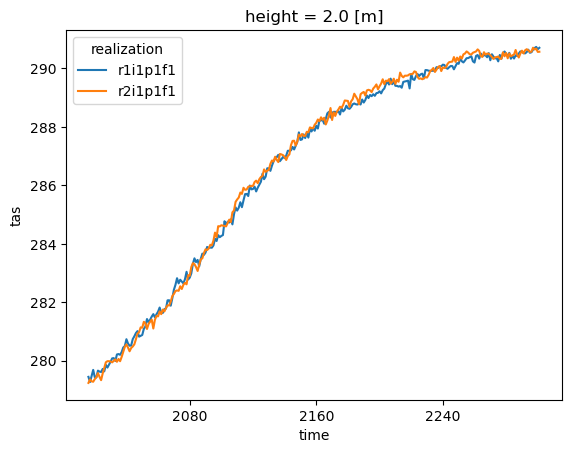

In [37]:
ds["tas"].mean(["lat", "lon"]).resample({"time": "Y"}).mean().plot.line(x="time")

Let's plot the accumulated precipitation over two periods of 20 years, the first period starting in 2015 and the second period starting in 2080.

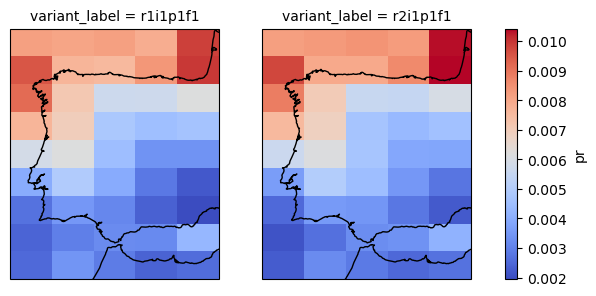

In [38]:
plot = ds["pr"].sel(lat=slice(35,45),lon=slice(350,360),time=slice("20150101", "20351231")).sum("time").plot(
        x="lon", y="lat", col="variant_label",
        add_colorbar=True,
        cmap="coolwarm",
        subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
        transform=ccrs.PlateCarree())

for ax in plot.axs.flatten():
    ax.coastlines()

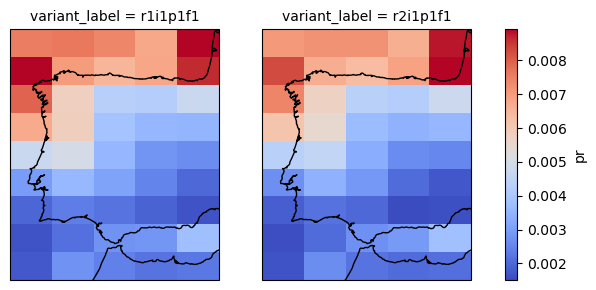

In [39]:
plot = ds["pr"].sel(lat=slice(35,45),lon=slice(350,360),time=slice("20800101", "21001231")).sum("time").plot(
        x="lon", y="lat", col="variant_label",
        add_colorbar=True,
        cmap="coolwarm",
        subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
        transform=ccrs.PlateCarree())

for ax in plot.axs.flatten():
    ax.coastlines()

In [40]:
ds.close()